# DATASET WITHOUT 'covid_year_timeline'

Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import itertools
from time import time

from sklearn.cluster import KMeans
from sklearn import metrics #import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.renderers
pio.renderers.default = "browser"

import Preprocess as pp
import Viz as viz

np.set_printoptions(precision = 3)

Set defaults

In [2]:
RANDOM_STATE = 42

df, column_trans, idx = pp.preprocessData()

log scaled ['total_sale_price', 'assessed_building_value', 'heated_area', 'unemploy_rate', 'pop_growth_rate', 'covid_cases', 'lumber_price', 'metals_price', 'supply', 'assessed_value_per_heated_area']
std scales ['story_height', 'mort_rate', 'build_price', 'int_rate', 'demand', 'year', 'crime']


Split the dataset in X and y.

In [3]:
X = df.drop(columns=['log_scaled__total_sale_price', 'passthru__covid_year_timeline'])
y = df['log_scaled__total_sale_price']

Showing how the original dataset is preprocessed and transformed.

In [4]:
column_trans

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['physical_zip_code', 'physical_city']),
                                ('log_scaled',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_sale_price', 'assessed_building_value',
                                  'heated_area', 'unemploy_rate',
                                  'pop_growth_r...vid_cases',
                                  'lumber_price', 'metals_price', 'supply',
                                  'assessed_value_per_heated_area']),
                                ('mm_scaled', MinMaxScaler(),
                                 ['bath_fixtures', 'bath']),
                                ('std_scale', StandardScaler(),
                                 ['story_height', 'mort_rate', 'build_price',
                                  'int_rate', 'demand', 'year', 'crime']),
                                ('passthru', 'passthrough',
                                 ['electric', 'gas', 'water', 'sewer', 'all',
                                  'is_covid', 'covid_year_timeline'])])

Showing the index of the columns in the dataframe based on preprocess methods.

In [5]:
idx

{'onehot': slice(0, 43, None),
 'log_scaled': slice(43, 53, None),
 'mm_scaled': slice(53, 55, None),
 'std_scale': slice(55, 62, None),
 'passthru': slice(62, 69, None),
 'remainder': slice(0, 0, None)}

# K-Means Clustering

We perform a Kmeans Clustering with the transformed dataset.

### Elbow Method

The below we see the elbow point as # of clusters reference. We have to be careful using this because it is less releveant when the elbow point is not obvious.
As seen below, the elbow point is not very obvious. So we move to check with Silhouette Score.

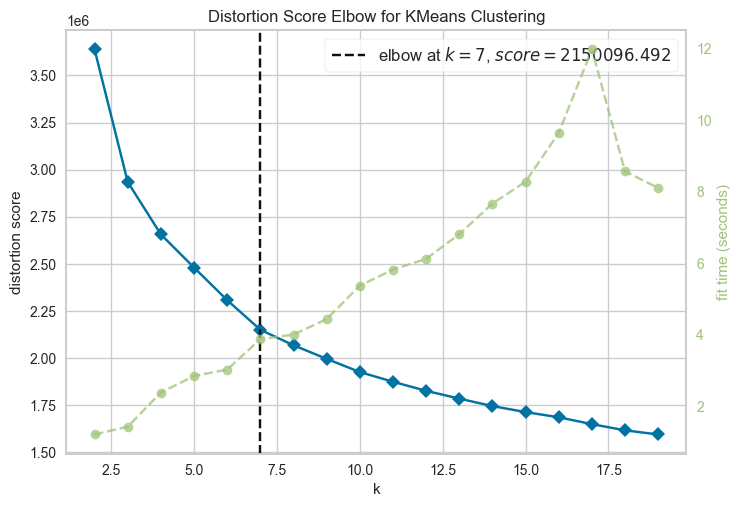

In [6]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)
k_start = 2
k_end = 20

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(k_start, k_end)).fit(X).show()  

### Silhouette Score & Inertia

This score shows the goodness of the clusters. The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

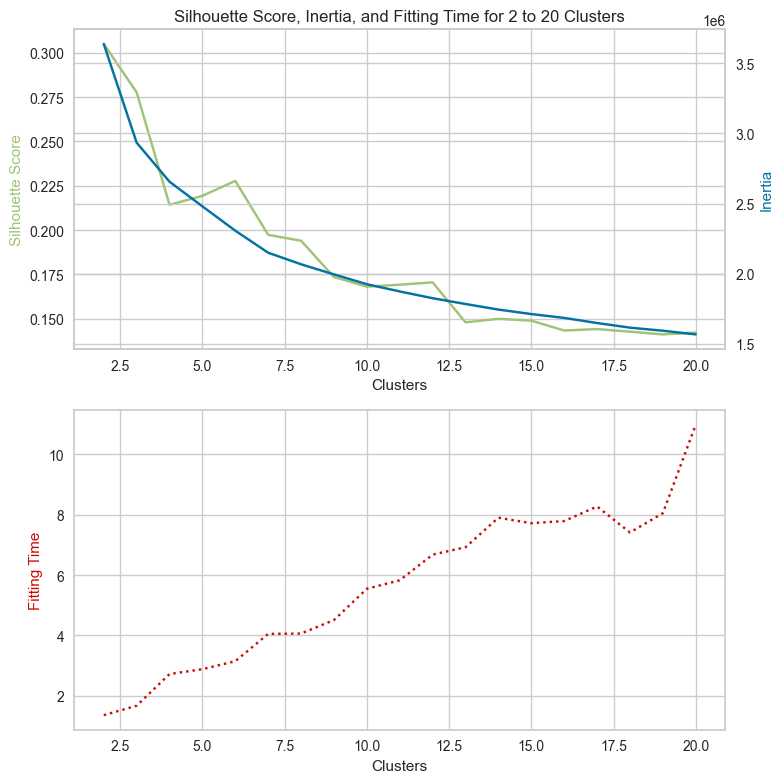

In [6]:
viz.plot_silhouette(X, kmeans=KMeans(init="k-means++", random_state=RANDOM_STATE))

Visualize Silhoutte Score and Scatter plot for 5, 6, 7 clusters because they have the high silhouette and low inertia.

We can see that they are not clustering well since some of the data point has negative silhouette scores.

For n_clusters = 5 The average silhouette_score is : 0.22651564450370534
For n_clusters = 6 The average silhouette_score is : 0.23369555157947844
For n_clusters = 7 The average silhouette_score is : 0.1974061707373259


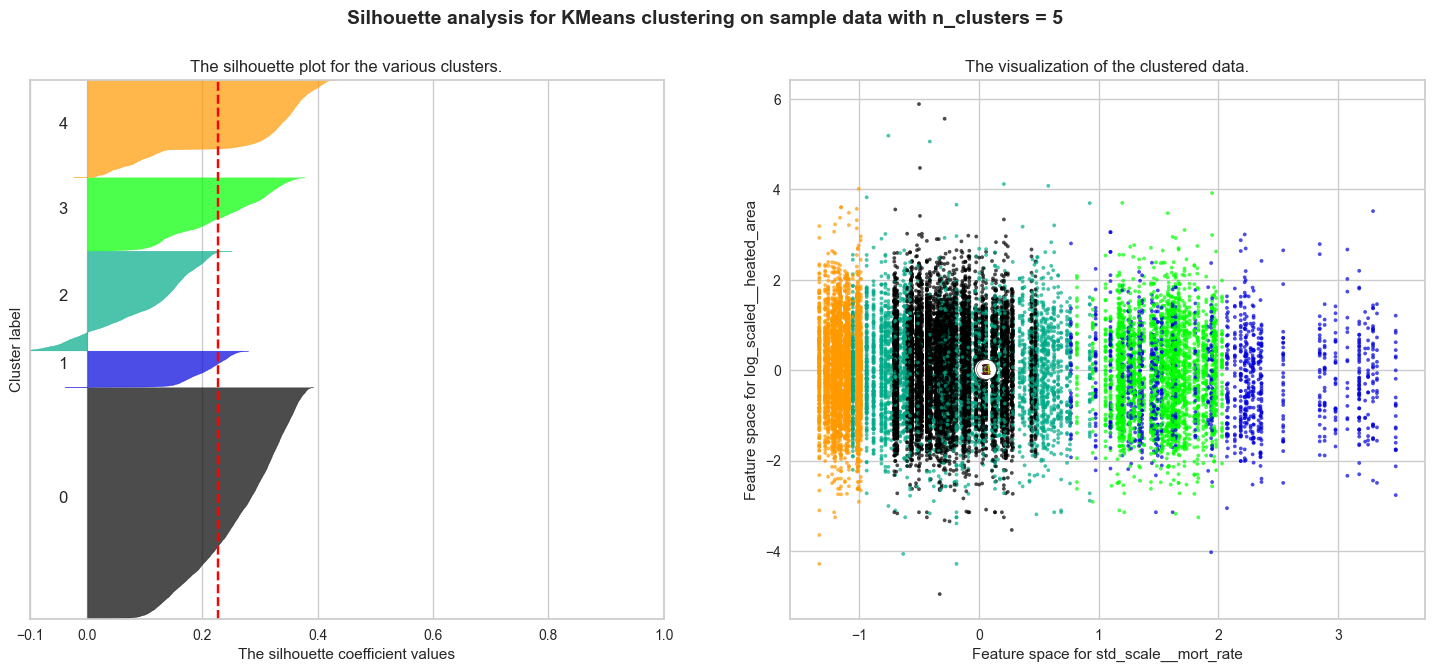

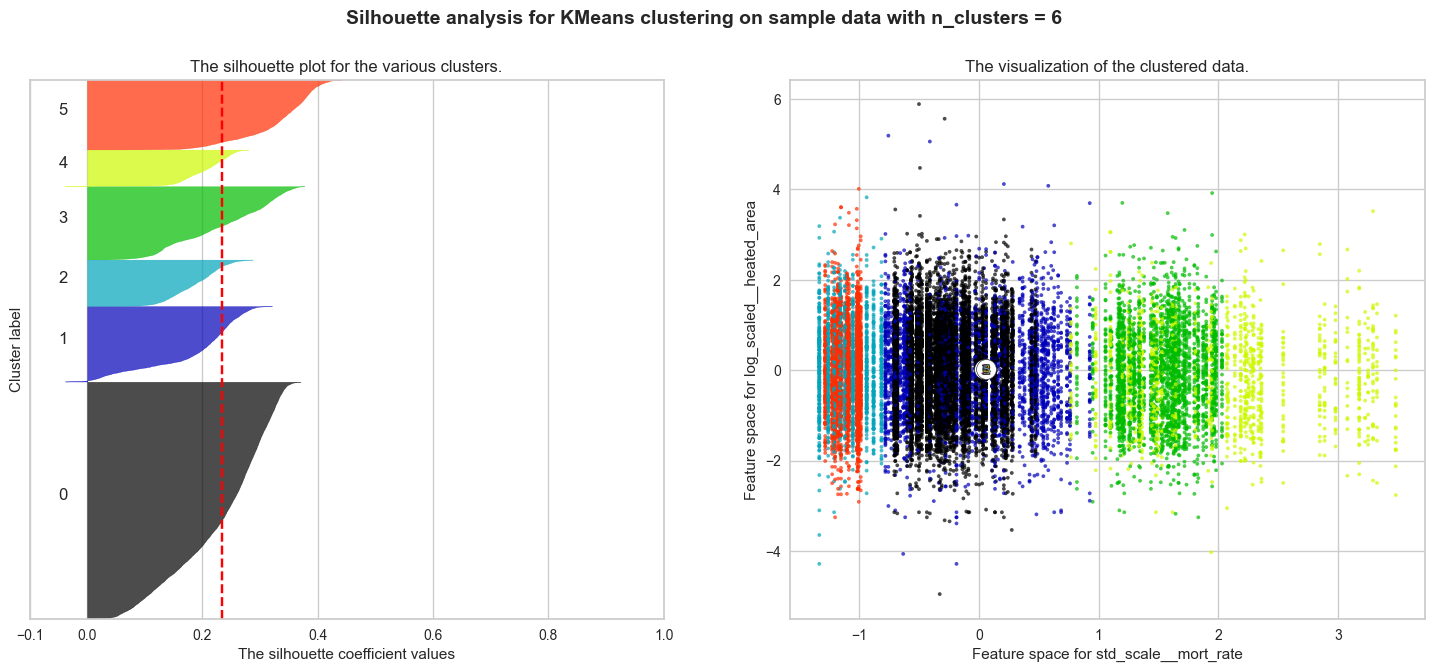

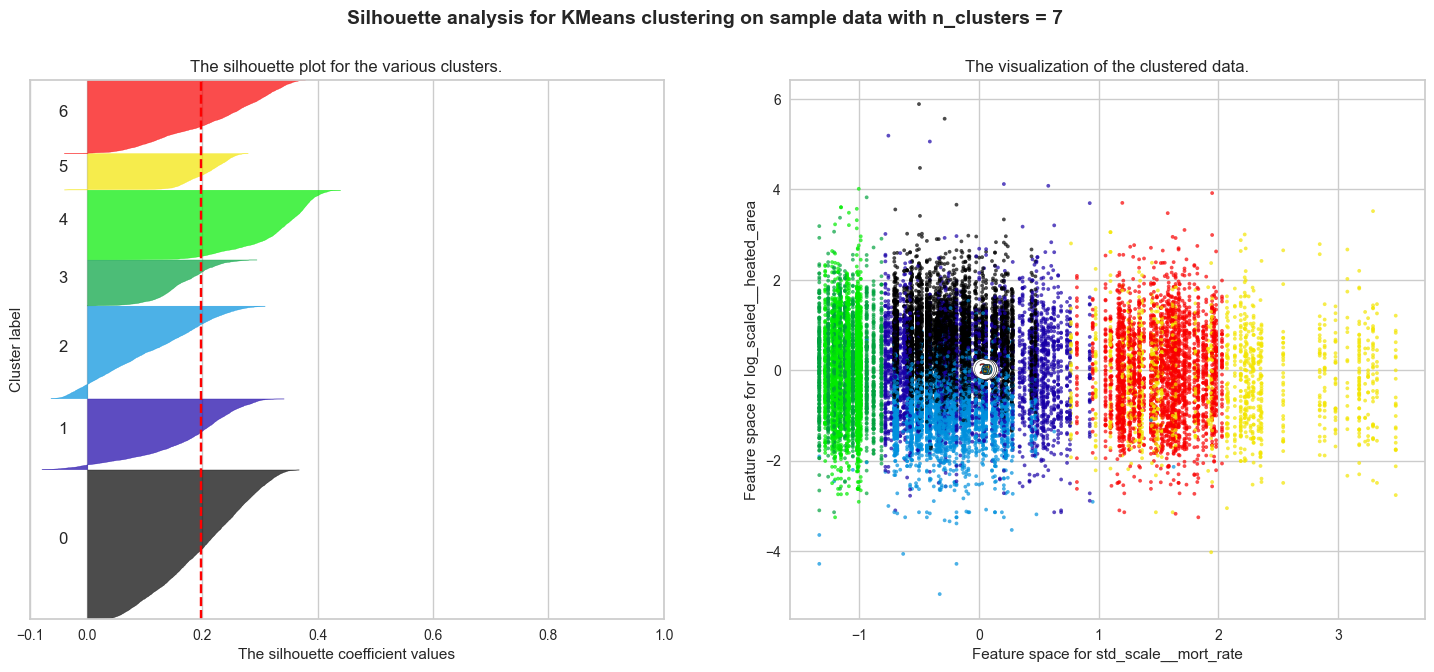

In [14]:
range_n_clusters = [5, 6, 7]
ax = 'std_scale__mort_rate'
ay = 'log_scaled__heated_area'

viz.draw_silhouette(X, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

# Kmeans with PCA

### PCA


PCA allows to project the data from the original 69-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space. - sklearn

In [8]:
pca = PCA(n_components=None, random_state=RANDOM_STATE)
pca.fit(X)
explained = pca.explained_variance_ratio_



Scree Plot helps us to visually decide how many PC to use. In practice, we take PCs with cumulative explained variance between 70% to 90%

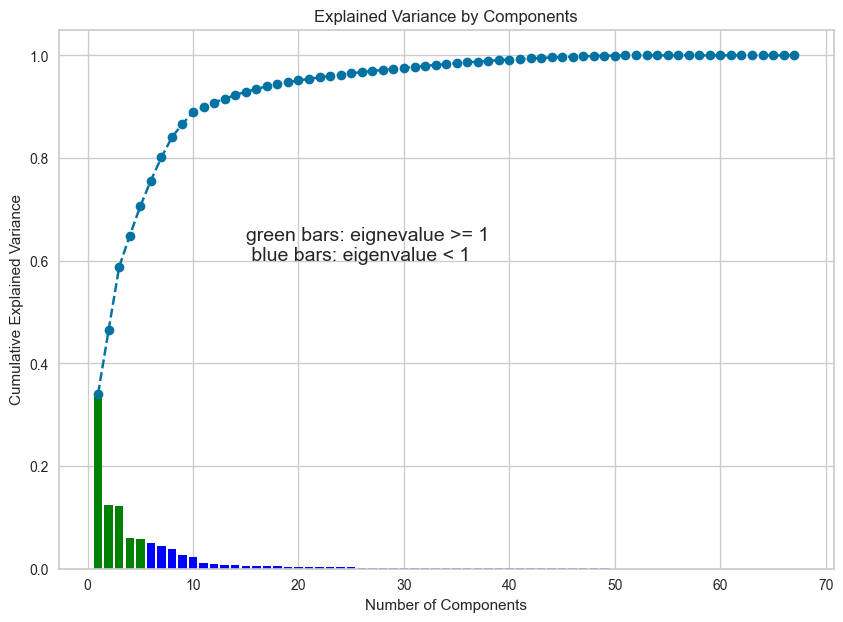

In [16]:
colors = ["green" if i >= 1 else "blue" for i in pca.explained_variance_]

plt.figure(figsize = (10,7))
plt.plot(range(1, len(explained)+1), explained.cumsum(), marker='o', linestyle = '--')
plt.bar(range(1, len(explained)+1), explained, color = colors),
plt.text(15, 0.6, 'green bars: eignevalue >= 1\n blue bars: eigenvalue < 1', fontsize = 14)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [17]:
pca.explained_variance_

array([6.320e+00, 2.308e+00, 2.277e+00, 1.123e+00, 1.064e+00, 9.273e-01,
       8.363e-01, 7.256e-01, 4.888e-01, 4.101e-01, 1.915e-01, 1.660e-01,
       1.369e-01, 1.342e-01, 1.161e-01, 1.012e-01, 1.000e-01, 8.159e-02,
       6.697e-02, 6.034e-02, 5.714e-02, 5.469e-02, 5.000e-02, 4.955e-02,
       4.622e-02, 4.259e-02, 4.139e-02, 3.999e-02, 3.884e-02, 3.662e-02,
       3.526e-02, 3.355e-02, 3.304e-02, 3.257e-02, 3.208e-02, 2.944e-02,
       2.892e-02, 2.726e-02, 2.549e-02, 2.055e-02, 2.034e-02, 1.963e-02,
       1.877e-02, 1.764e-02, 1.459e-02, 1.400e-02, 1.247e-02, 1.127e-02,
       8.044e-03, 5.633e-03, 5.102e-03, 1.677e-03, 1.043e-03, 7.737e-04,
       1.738e-06, 8.431e-27, 5.790e-27, 4.384e-27, 3.955e-27, 3.158e-27,
       2.724e-27, 2.618e-27, 1.279e-27, 9.723e-28, 9.000e-28, 2.642e-28,
       1.246e-30])

In [10]:
pca.explained_variance_ratio_

array([3.409e-01, 1.245e-01, 1.228e-01, 6.059e-02, 5.738e-02, 5.001e-02,
       4.511e-02, 3.914e-02, 2.636e-02, 2.212e-02, 1.033e-02, 8.951e-03,
       7.385e-03, 7.239e-03, 6.264e-03, 5.457e-03, 5.396e-03, 4.401e-03,
       3.612e-03, 3.254e-03, 3.082e-03, 2.950e-03, 2.697e-03, 2.672e-03,
       2.493e-03, 2.297e-03, 2.233e-03, 2.157e-03, 2.095e-03, 1.975e-03,
       1.902e-03, 1.809e-03, 1.782e-03, 1.757e-03, 1.730e-03, 1.588e-03,
       1.560e-03, 1.470e-03, 1.375e-03, 1.108e-03, 1.097e-03, 1.059e-03,
       1.013e-03, 9.514e-04, 7.869e-04, 7.552e-04, 6.724e-04, 6.081e-04,
       4.339e-04, 3.038e-04, 2.752e-04, 9.046e-05, 5.626e-05, 4.173e-05,
       9.375e-08, 4.547e-28, 3.123e-28, 2.364e-28, 2.133e-28, 1.703e-28,
       1.469e-28, 1.412e-28, 6.901e-29, 5.244e-29, 4.854e-29, 1.425e-29,
       6.722e-32])

The eigenvalues (variance explained by each PC) for PCs can help to retain the number of PCs. According to Kaiser’s rule, PCs with eigenvalues > 1 contributes greater variance and should be retained for further analysis. 

We have 5 PC with eigenvalues > 1, but since we see a few more PCs helped to bring the cumulative explained variance ratio to nearly 90%, we will use 10 PC to continue with clustering.

### PCA with 10 Components

The below shows the loadings of each feature relative to the PC:
* PC1 (34.1%) relates to macro factors i.e. mortgage rate, interest rate, and population growth.
* PC2 (12.5%) relates to housing demand and unemployment rates.
* PC3 (12.3%) relates to housing supply, lumber prices, and covid cases. 
* The rest of the less significant PCs relates more to the phycical build and location of the property

Covid cases come in PC3 where PC3 only explained 12.3% of the variance in the data. 

Shape before PCA:  (259024, 67)
Shape after PCA:  (259024, 10)


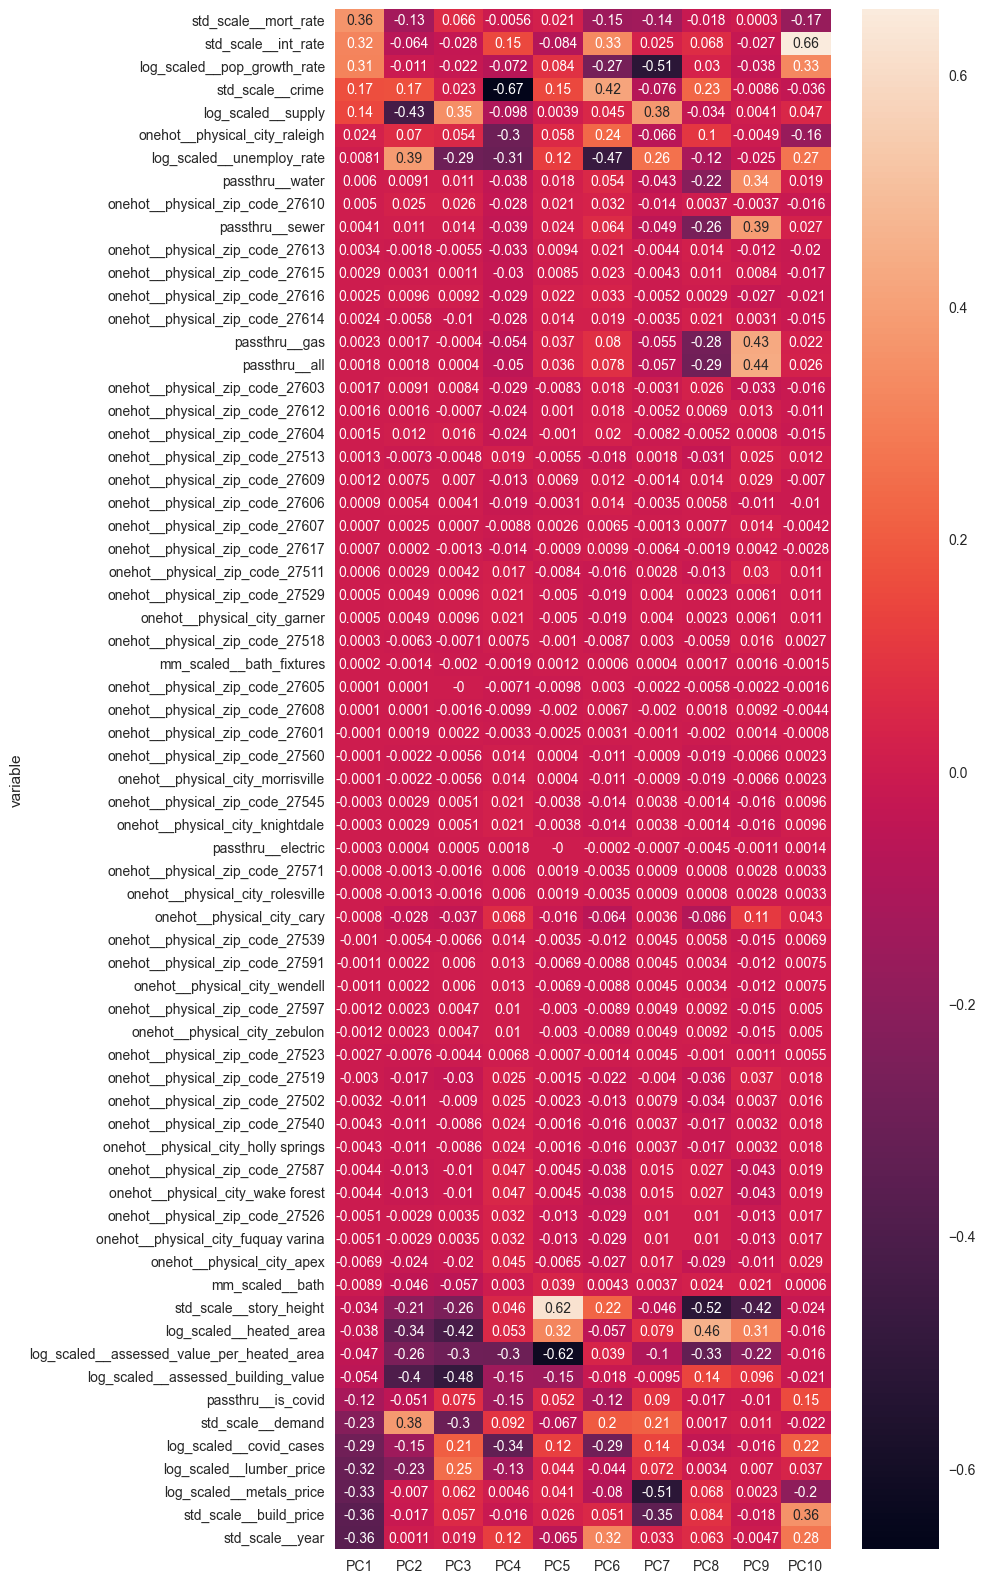

In [23]:
n = 10
pca_n = PCA(n_components=n, random_state=RANDOM_STATE)
pca_n_out_matrix = pca_n.fit_transform(X)

pca_n_explained = pca_n.explained_variance_ # explained variance
pca_n_explained_ratio = pca_n.explained_variance_ratio_ # Proportion of Variance (from PC1 to PC6)
pca_n_explained_cumratio = np.cumsum(pca_n.explained_variance_ratio_) # Cumulative proportion of variance (from PC1 to PC6)   

# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
pca_n_loadings = pca_n.components_
num_pc = pca_n.n_features_
names_pc = ['PC'+str(i) for i in range(1,n+1)]

loadings_df = pd.DataFrame.from_dict(dict(zip(names_pc, pca_n_loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable').round(4).sort_values(by=names_pc, ascending=False)
#loadings_df.to_html('pca_n_component_loadings_noTL.html')

plt.figure(figsize=(8,20))
sns.heatmap(loadings_df, annot=True, annot_kws={"size": 10})
plt.savefig('pca_n_component_loadings_heatmap_noTL.png')
#fig = px.imshow(loadings_df, text_auto=True, color_continuous_scale='RdBu_r')
#fig.write_html('pca_n_heatmap.html')
#fig.show()

# positive and negative values in component loadings reflects the positive and negative 
# correlation of the variables with the PCs. 

print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_n_out_matrix.shape)


We perform PCA with the chosen number of components below:

Scree Plot of n_components = 10

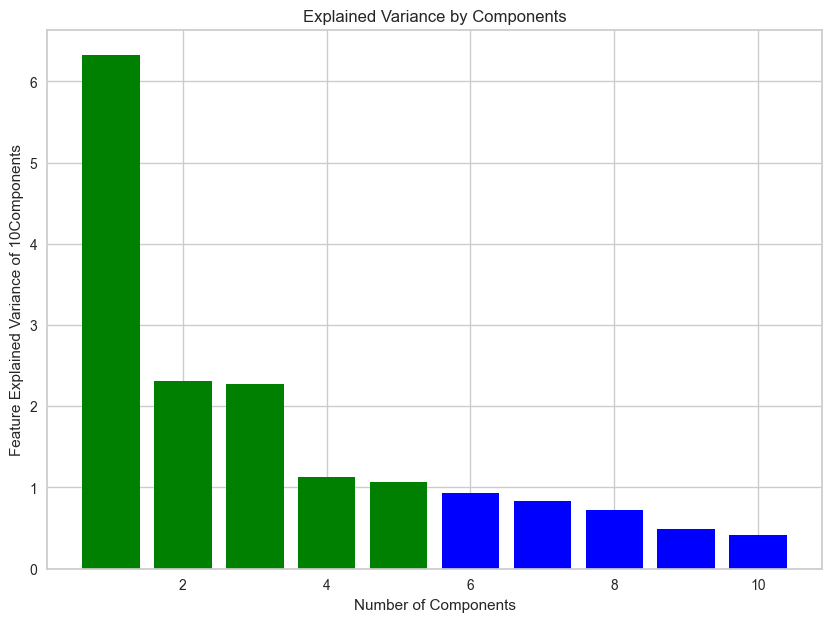

In [24]:
plt.figure(figsize = (10,7))
#plt.plot(range(1, len(pca_n_explained)+1), pca_n_explained.cumsum(), marker='o', linestyle = '--')
plt.bar(range(1, len(pca_n_explained)+1), pca_n_explained, color = colors)
#plt.text(15, 0.6, 'green bars: eignevalue >= 1\n blue bars: eigenvalue < 1', fontsize = 14)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Feature Explained Variance of '+str(n)+'Components')
plt.show()

ref: https://www.reneshbedre.com/blog/principal-component-analysis.html#pca-loadings-plots

In [25]:
# change the pca-transformed matrix to df

pca_n_df = pd.DataFrame(pca_n_out_matrix, columns=names_pc)

### Try Kmeans again using PCA matrix

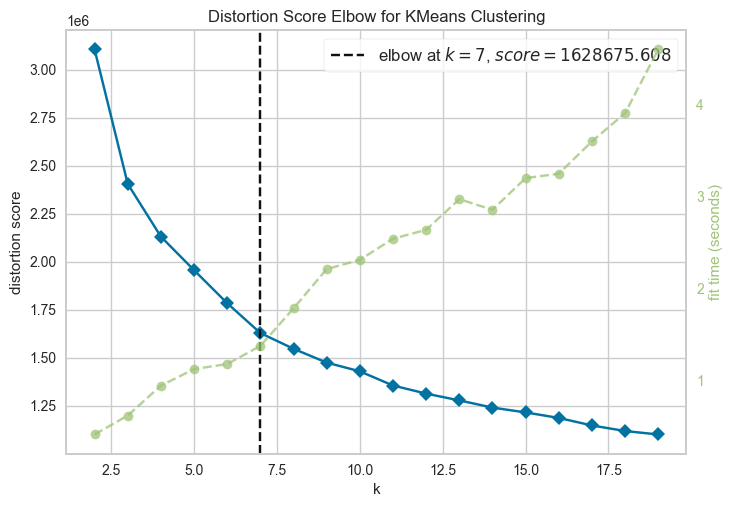

In [26]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(2,20)).fit(pca_n_out_matrix).show()  

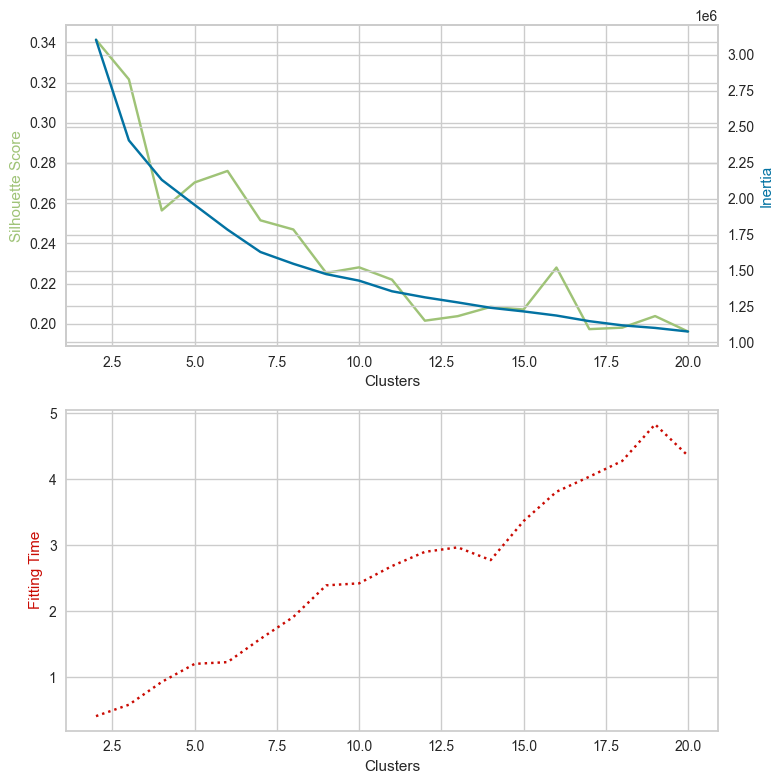

In [27]:
viz.plot_silhouette(pca_n_out_matrix, kmeans=KMeans(init="k-means++", random_state=RANDOM_STATE))

We will use 6 clusters here as it give high silhouette and low inertia. But we still see some bad cluster points with negative silhouette scores.

For n_clusters = 5 The average silhouette_score is : 0.27458055603132653
For n_clusters = 6 The average silhouette_score is : 0.23466716398695353
For n_clusters = 7 The average silhouette_score is : 0.24892220644975135


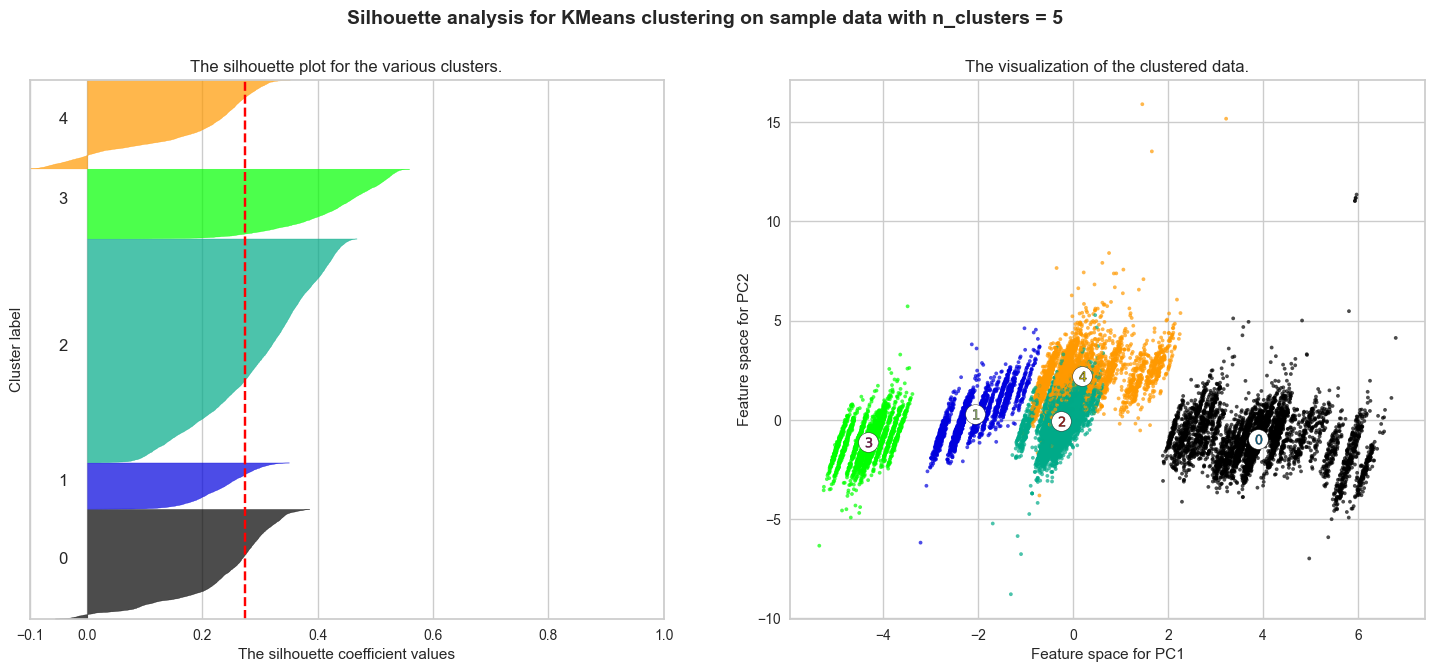

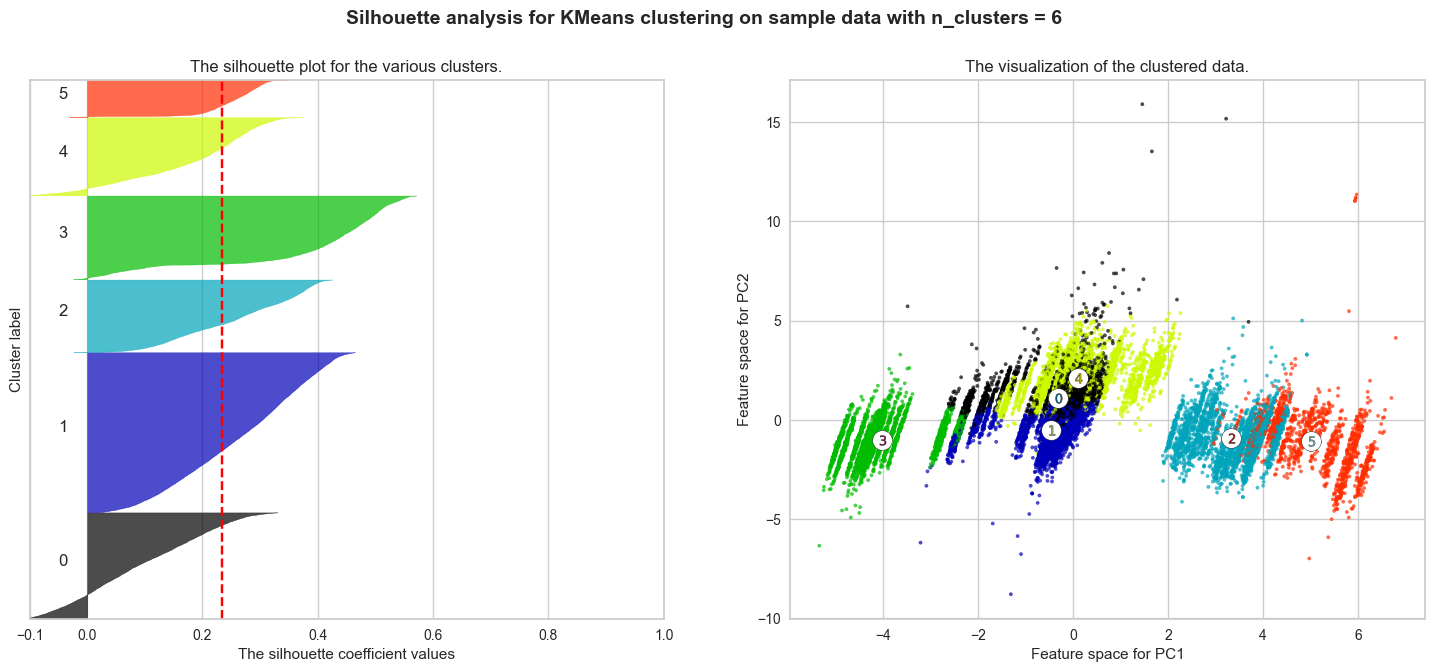

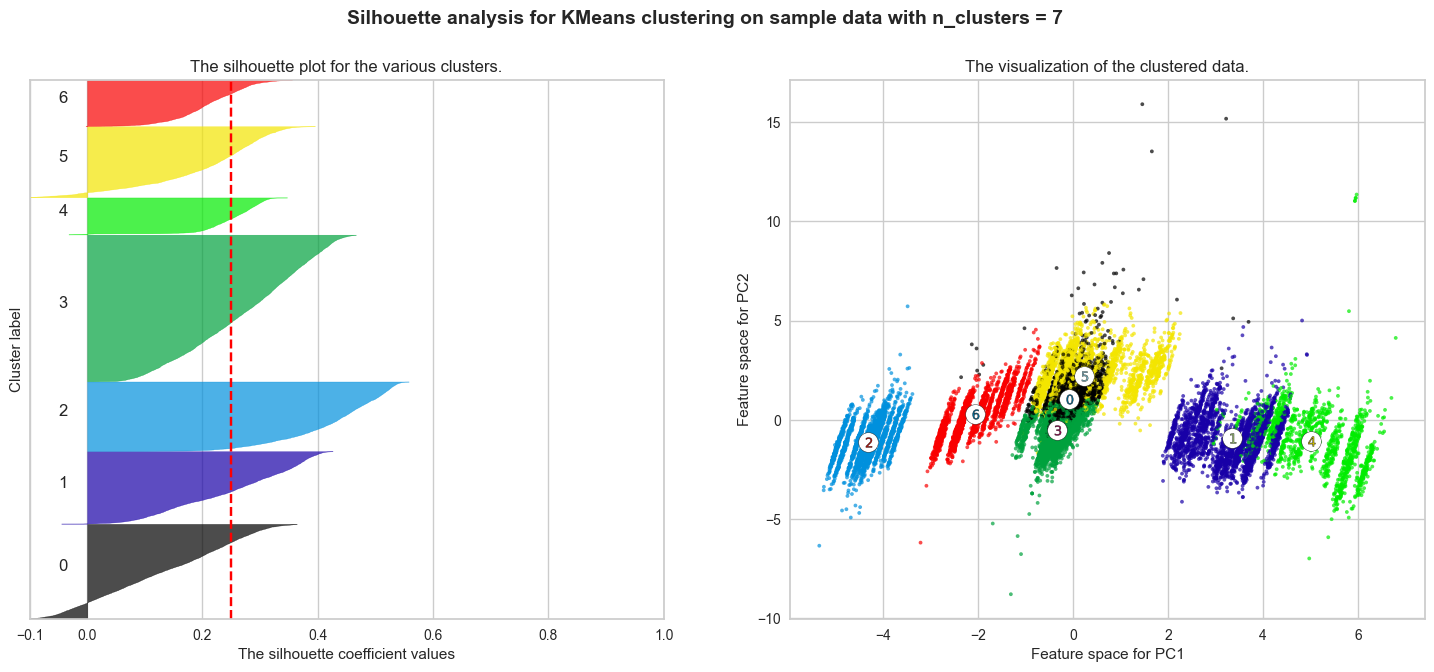

In [28]:
range_n_clusters = [5, 6, 7]
ax = 'PC1'
ay = 'PC2'

viz.draw_silhouette(pca_n_df, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

So, let's decide we will use 6 clusters. We construct the full df for original preprocessing features, PC features, and cluster labels

In [31]:
#K-means clustering with PCA results
kmeans = KMeans(init='k-means++', n_clusters=6, random_state=RANDOM_STATE)
kmeans.fit_transform(X)

# create a new DF with original features and add PCA scores and assigned clusters
pca_kmeans_df = pd.concat([X.reset_index(drop=True), pd.DataFrame(pca_n_out_matrix)], axis =1)
pca_kmeans_df.columns.values[-n:] = names_pc

# add the last column with the clustering labels
pca_kmeans_df['ClusterLabels'] = kmeans.labels_

# name the clusters segments
#df_seg_pca_kmeans['Segments'] = df_seg_pca_kmeans['ClusterLabels'].map({0:''})

pca_kmeans_df.head()

,onehot__physical_zip_code_27502,onehot__physical_zip_code_27511,onehot__physical_zip_code_27513,onehot__physical_zip_code_27518,onehot__physical_zip_code_27519,onehot__physical_zip_code_27523,onehot__physical_zip_code_27526,onehot__physical_zip_code_27529,onehot__physical_zip_code_27539,onehot__physical_zip_code_27540,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,ClusterLabels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.660641,3.135174,-0.564857,-1.325054,1.288615,2.276118,1.165322,-1.106582,-0.810921,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.903150,2.602771,-0.707562,-0.719731,1.421506,2.265557,0.651393,0.920597,-0.636341,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.024205,1.442944,-0.581364,0.823604,1.926994,2.126956,-0.043638,0.295539,-0.802025,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.238319,2.879871,-0.323106,-0.445838,1.787279,2.120999,1.032917,1.130310,-0.843401,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.396011,3.453621,-0.618633,-1.025532,1.568740,2.086125,0.071431,0.513793,-0.703252,5


### K-means clustering with PCA results

In [ ]:
# Biplot - same thing as above but now with PC and loadings
loadings = pca_n.components_.T * np.sqrt(pca_n.explained_variance_)
features = X.columns.to_list()
color = pca_kmeans_df['ClusterLabels'].astype(str)

fig = px.scatter(
    pca_n_out_matrix, x=0, y=1, color=color,
    color_discrete_sequence=px.colors.qualitative.Set2,
    #color_continuous_scale=px.colors.sequential.Purpor #px.colors.diverging.Sunset
)
fig.update_traces(marker_size = 2)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
        )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        )

fig.write_html("pca_biplot_without_covid_timeline_noTL.html")
#fig.show()



In [ ]:
#selected_k=4

#Overlaying Clusters on Scaled Data

#viz.draw_cluster_scatter(X, k=selected_k, random_state=RANDOM_STATE)

